In [1048]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [1031]:
data = pd.read_csv("../Patrick/race_predictor_data.csv")

continuous_features_dnf = ['averageCumRacerPoints', 'averageDriverExpYears', 'avgDriverRaceCount', 'qualifyingALPC', 'FRALPC',
                           'avgDriverLapStop', 'TCCAPE', 'pacePosDiff', 'paceALPC', 'avgDriverPSTime']
categorical_features_dnf = ['topTenDiversity', 'circuitId', 
                            'countryId']
continuous_features_alpc = ['averageCumRacerPoints', 'averageDriverExpYears', 'avgDriverRaceCount', 'qualifyingALPC', 'FRALPC',
                            'paceALPC']
categorical_features_alpc = ['topTenDiversity']

alpc_cont_feat = ['qualifyingALPC', 'FRALPC', 'paceALPC', 'pacePosDiff', 'averageCumRacerPoints', 'averageDriverExpYears', 
                  'avgDriverRaceCount', 'TCCAPE', 'avgDriverLapStop']
alpc_cat_feat = ['topTenDiversity']

dnf_features = continuous_features_dnf + categorical_features_dnf
alpc_features = continuous_features_alpc + categorical_features_alpc
alpc_feat = alpc_cat_feat + alpc_cont_feat

target = 'totalDNFs'
alpc_target = 'ALPC'

X_dnf = data[dnf_features]
X_alpc = data[alpc_feat]
y = data[target]
y2 = data[alpc_target]

In [1032]:
X_train, X_test, y_train, y_test, y2_train, y2_test = train_test_split(X_dnf, y, y2, 
                                                                       test_size    = 0.2,
                                                                       shuffle      = True,
                                                                       random_state = 659)

In [1033]:
k_fold = KFold(n_splits     = 7,
               shuffle      = True,
               random_state = 659)

In [1034]:
handle_nans = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

transform_continuous_data = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree           = 2,
                                      interaction_only = False,
                                      include_bias     = False))
])

transform_categorical_data = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', 
                             drop           = 'first'))
])

linear_preprocessor = ColumnTransformer([
    ('fillnans', handle_nans, continuous_features_dnf),
    ('cat', transform_categorical_data, categorical_features_dnf)
])

polynomial_preprocessor = ColumnTransformer([
    ('cont', transform_continuous_data, continuous_features_dnf),
    ('cat', transform_categorical_data, categorical_features_dnf)
])

linear_regress = Pipeline([
    ('preprocess', linear_preprocessor),
    ('model', LinearRegression())
])

nonlinear_regress = Pipeline([
    ('preprocess', polynomial_preprocessor),
    ('model', LinearRegression())
])

In [1035]:
linear_mse_scores, linear_r2_scores = [], []
nonlinear_mse_scores, nonlinear_r2_scores = [], []

for train_index, val_index in k_fold.split(X_dnf):
    X_kf_train, X_val = X_dnf.iloc[train_index], X_dnf.iloc[val_index]
    y_kf_train, y_val = y.iloc[train_index], y.iloc[val_index]

    linear_regress.fit(X_kf_train, y_kf_train)
    nonlinear_regress.fit(X_kf_train, y_kf_train)
    linear_y_pred = linear_regress.predict(X_val)
    nonlinear_y_pred = nonlinear_regress.predict(X_val)

    linear_mse = mean_squared_error(y_val, linear_y_pred)
    linear_r2 = r2_score(y_val, linear_y_pred)
    nonlinear_mse = mean_squared_error(y_val, nonlinear_y_pred)
    nonlinear_r2 = r2_score(y_val, nonlinear_y_pred)

    linear_mse_scores.append(linear_mse)
    linear_r2_scores.append(linear_r2)
    nonlinear_mse_scores.append(nonlinear_mse)
    nonlinear_r2_scores.append(nonlinear_r2)

# Report average metrics
print(f"Average Linear MSE: {np.mean(linear_mse_scores):.4f}")
print(f"Average Linear R²: {np.mean(linear_r2_scores):.4f}")
print(f"Average Nonlinear MSE: {np.mean(nonlinear_mse_scores):.4f}")
print(f"Average Nonlinear R²: {np.mean(nonlinear_r2_scores):.4f}")

/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Average Linear MSE: 6.8991
Average Linear R²: 0.6434
Average Nonlinear MSE: 6.8305
Average Nonlinear R²: 0.6470


/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [1050]:
linear_cv_results = cross_validate(linear_regress, X_dnf, y,
                                   cv=k_fold,
                                   scoring=('r2', 'neg_mean_squared_error'),
                                   return_train_score=True)

# For nonlinear model
nonlinear_cv_results = cross_validate(nonlinear_regress, X_dnf, y,
                                      cv=k_fold,
                                      scoring=('r2', 'neg_mean_squared_error'),
                                      return_train_score=True)

def summarize_cv_results(results, model_name="Model"):
    r2_scores = results['test_r2']
    mse_scores = -results['test_neg_mean_squared_error']  # Convert back to positive MSE

    print(f"\n{model_name} Cross-Validation Summary:")
    print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

summarize_cv_results(linear_cv_results, "Linear Model")
summarize_cv_results(nonlinear_cv_results, "Nonlinear Model")

/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Linear Model Cross-Validation Summary:
Average R²: 0.6434 ± 0.0428
Average MSE: 6.8991 ± 0.8764

Nonlinear Model Cross-Validation Summary:
Average R²: 0.6470 ± 0.0528
Average MSE: 6.8305 ± 1.0772


/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. Thes

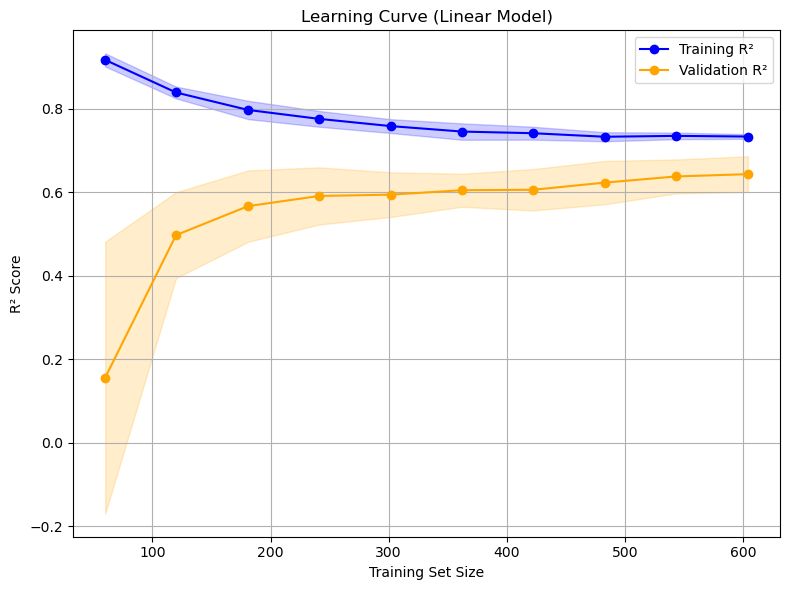

/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. Thes

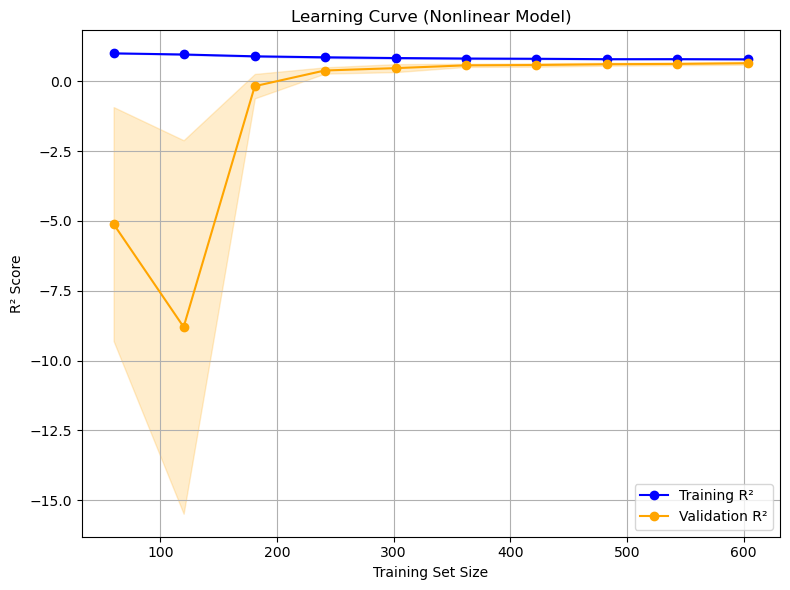

In [1051]:
def plot_learning_curve(estimator, X_dnf, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_dnf, y, cv=k_fold, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation R²')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(linear_regress, X_dnf, y, title="Learning Curve (Linear Model)")
plot_learning_curve(nonlinear_regress, X_dnf, y, title="Learning Curve (Nonlinear Model)")

In [1036]:
lin_y_pred = linear_regress.predict(X_test) 
nonlin_y_pred = nonlinear_regress.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_y_pred)
lin_r2 = r2_score(y_test, lin_y_pred)
nonlin_mse = mean_squared_error(y_test, nonlin_y_pred)
nonlin_r2 = r2_score(y_test, nonlin_y_pred)

print(f"Mean squared error (Linear Model): {lin_mse}")
print(f"R^2 value (Linear Model): {lin_r2}")
print(f"Mean squared error (Nonlinear Model): {nonlin_mse}")
print(f"R^2 value (Nonlinear Model): {nonlin_r2}")

Mean squared error (Linear Model): 5.363844255599277
R^2 value (Linear Model): 0.7285306561642247
Mean squared error (Nonlinear Model): 4.367642312012129
R^2 value (Nonlinear Model): 0.7789493997120485


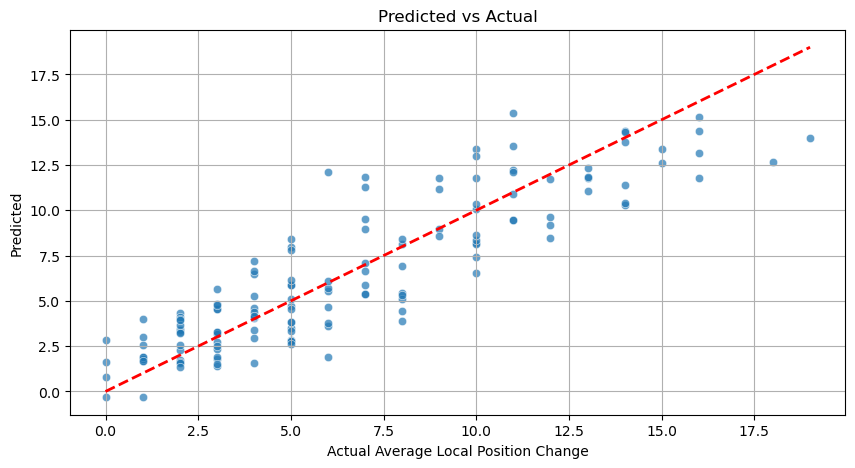

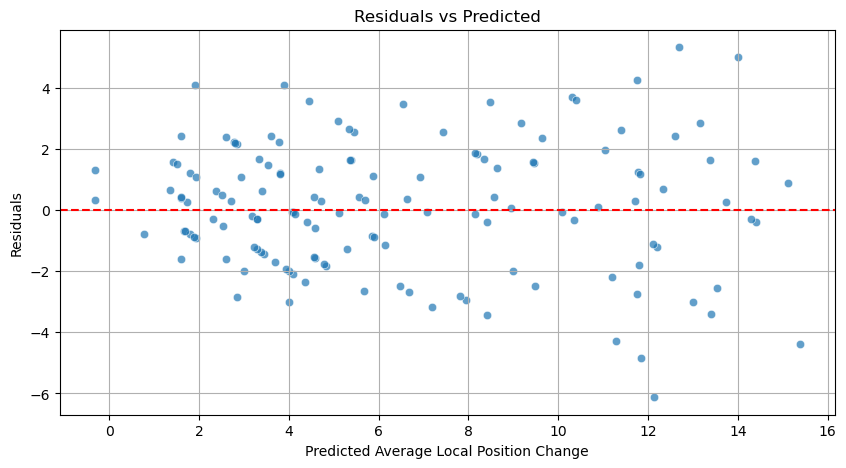

In [1037]:
# Predicted vs Actual
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=nonlin_y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Average Local Position Change")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_test - nonlin_y_pred

plt.figure(figsize=(10, 5))
sns.scatterplot(x=nonlin_y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Average Local Position Change")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

In [1038]:
linear_preprocessor_2 = ColumnTransformer([
    ('fillnans', handle_nans, continuous_features_alpc),
    ('cat', transform_categorical_data, categorical_features_alpc)
])

polynomial_preprocessor_2 = ColumnTransformer([
    ('cont', transform_continuous_data, continuous_features_alpc),
    ('cat', transform_categorical_data, categorical_features_alpc)
])

linear_regress_2 = Pipeline([
    ('preprocess', linear_preprocessor_2),
    ('model', LinearRegression())
])

nonlinear_regress_2 = Pipeline([
    ('preprocess', polynomial_preprocessor_2),
    ('model', LinearRegression())
])

In [1039]:
kf = KFold(n_splits     = 7, 
           shuffle      = True, 
           random_state = 659)

oof_preds = cross_val_predict(
    nonlinear_regress, X_train, y2_train,
    cv = kf,
    method = 'predict'
).reshape(-1, 1)

/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/winter-storm/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categ

In [1040]:
nonlinear_regress.fit(X_train, y2_train)
test_preds = nonlinear_regress.predict(X_test).reshape(-1, 1)
nonlinear_regress_2.fit(X_train[alpc_features], y2_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['averageCumRacerPoints',
                                                   'averageDriverExpYears',
                                                   'avgDriverRaceCount',
                                                   'qualifyingALPC', 'FRALPC',
                                                   'paceALPC']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['topTenDiversity'])])),
                ('model', LinearRegression())])

In [1041]:
# 2. Encode ALPC features only
X_train_encoded = nonlinear_regress_2.named_steps['preprocess'].transform(X_train[alpc_features])
X_test_encoded = nonlinear_regress_2.named_steps['preprocess'].transform(X_test[alpc_features])

# Convert to dense if needed
if issparse(X_train_encoded):
    X_train_encoded = X_train_encoded.toarray()
    X_test_encoded = X_test_encoded.toarray()

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train_encoded)
X_test_df = pd.DataFrame(X_test_encoded)

# Add OOF predictions as feature
X_train_stack = pd.concat([X_train_df, pd.DataFrame(oof_preds, columns=['linear_pred'])], axis=1)
X_test_stack = pd.concat([X_test_df, pd.DataFrame(test_preds, columns=['linear_pred'])], axis=1)

# Fix mixed column name types
X_train_stack.columns = X_train_stack.columns.astype(str)
X_test_stack.columns = X_test_stack.columns.astype(str)

In [1042]:
alpc_model = GradientBoostingRegressor()
#alpc_model = RandomForestRegressor()
alpc_model.fit(X_train_stack, y2_train)

# Predict and evaluate
y2_pred_stack = alpc_model.predict(X_test_stack)

print("MSE:", mean_squared_error(y2_test, y2_pred_stack))
print("R²: ", r2_score(y2_test, y2_pred_stack))

MSE: 0.7953481984152256
R²:  0.13930014348916275


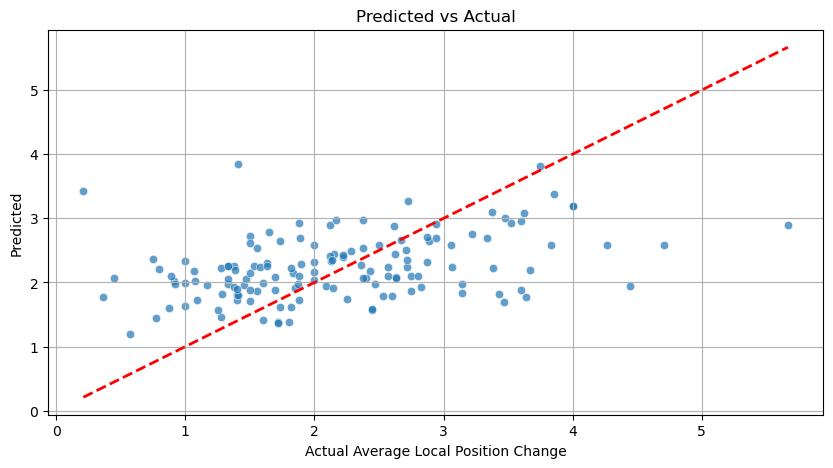

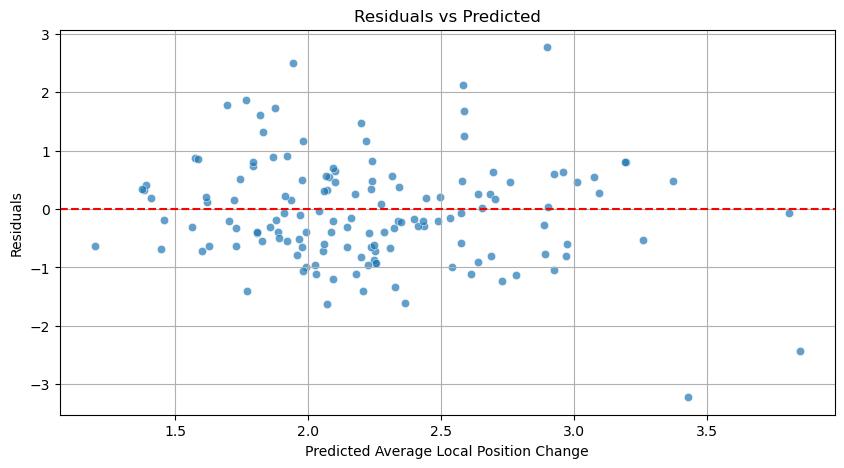

In [1043]:
# Predicted vs Actual
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y2_test, y=y2_pred_stack, alpha=0.7)
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], 'r--', lw=2)
plt.xlabel("Actual Average Local Position Change")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Residual Plot
residuals = y2_test - y2_pred_stack

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y2_pred_stack, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Average Local Position Change")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

In [1044]:
X2_train, X2_test = train_test_split(X_alpc, 
                                     test_size    = 0.2,
                                     shuffle      = True,
                                     random_state = 659)

In [1045]:
linear_preprocessor_alpc = ColumnTransformer([
    ('fillnans', handle_nans, alpc_cont_feat),
    ('cat', transform_categorical_data, alpc_cat_feat)
])

polynomial_preprocessor_alpc = ColumnTransformer([
    ('cont', transform_continuous_data, alpc_cont_feat),
    ('cat', transform_categorical_data, alpc_cat_feat)
])

linear_regress_alpc = Pipeline([
    ('preprocess', linear_preprocessor_alpc),
    ('model', LinearRegression())
])

nonlinear_regress_alpc = Pipeline([
    ('preprocess', polynomial_preprocessor_alpc),
    ('model', LinearRegression())
])

In [1046]:
linear_mse_scores_alpc, linear_r2_scores_alpc = [], []
nonlinear_mse_scores_alpc, nonlinear_r2_scores_alpc = [], []

for train_index, val_index in k_fold.split(X_alpc):
    X_kf_train, X_val = X_alpc.iloc[train_index], X_alpc.iloc[val_index]
    y_kf_train, y_val = y2.iloc[train_index], y2.iloc[val_index]

    linear_regress_alpc.fit(X_kf_train, y_kf_train)
    nonlinear_regress_alpc.fit(X_kf_train, y_kf_train)
    linear_y_pred = linear_regress_alpc.predict(X_val)
    nonlinear_y_pred = nonlinear_regress_alpc.predict(X_val)

    linear_mse = mean_squared_error(y_val, linear_y_pred)
    linear_r2 = r2_score(y_val, linear_y_pred)
    nonlinear_mse = mean_squared_error(y_val, nonlinear_y_pred)
    nonlinear_r2 = r2_score(y_val, nonlinear_y_pred)

    linear_mse_scores_alpc.append(linear_mse)
    linear_r2_scores_alpc.append(linear_r2)
    nonlinear_mse_scores_alpc.append(nonlinear_mse)
    nonlinear_r2_scores_alpc.append(nonlinear_r2)

# Report average metrics
print(f"Average Linear MSE: {np.mean(linear_mse_scores_alpc):.4f}")
print(f"Average Linear R²: {np.mean(linear_r2_scores_alpc):.4f}")
print(f"Average Nonlinear MSE: {np.mean(nonlinear_mse_scores_alpc):.4f}")
print(f"Average Nonlinear R²: {np.mean(nonlinear_r2_scores_alpc):.4f}")

Average Linear MSE: 0.7325
Average Linear R²: 0.1703
Average Nonlinear MSE: 0.7594
Average Nonlinear R²: 0.1409


In [1047]:
lin_y2_pred = linear_regress_alpc.predict(X2_test) 
nonlin_y2_pred = nonlinear_regress_alpc.predict(X2_test)

lin_mse_alpc = mean_squared_error(y2_test, lin_y2_pred)
lin_r2_alpc = r2_score(y2_test, lin_y2_pred)
nonlin_mse_alpc = mean_squared_error(y2_test, nonlin_y2_pred)
nonlin_r2_alpc = r2_score(y2_test, nonlin_y2_pred)

print(f"Mean squared error (Linear Model): {lin_mse_alpc}")
print(f"R^2 value (Linear Model): {lin_r2_alpc}")
print(f"Mean squared error (Nonlinear Model): {nonlin_mse_alpc}")
print(f"R^2 value (Nonlinear Model): {nonlin_r2_alpc}")

Mean squared error (Linear Model): 0.7829617570670777
R^2 value (Linear Model): 0.15270434596585591
Mean squared error (Nonlinear Model): 0.7004327993973882
R^2 value (Nonlinear Model): 0.24201448983218665
